In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import scipy.stats as st

### Read In CSVs

In [3]:
raw_combine_data=pd.read_csv('Resources/raw_combine_data.csv')
raw_nba_data=pd.read_csv('Resources/raw_nba_data.csv')

### Finding Duplicates

In [4]:
nba_duplicates=raw_nba_data[raw_nba_data.duplicated(['PLAYER'])]
combine_duplicates=raw_combine_data[raw_combine_data.duplicated(['PLAYER'])]

### Drop Duplicates from Dataframes

In [5]:
dropped_combine_data=raw_combine_data.drop_duplicates(subset='PLAYER',keep='first')
dropped_nba_data=raw_nba_data.drop_duplicates(subset='PLAYER',keep='first')

### Merge DataFrames

In [6]:
merged_data_df=dropped_combine_data.merge(dropped_nba_data, on='PLAYER')

### Remove Players Who Didn't Take Enough Shots to Include in Analysis

In [7]:
merged_data_df=merged_data_df[merged_data_df['3PA']>10]
merged_data_df=merged_data_df[merged_data_df['2PA']>10]
merged_data_df=merged_data_df[merged_data_df['FTA']>10]

### Drop Rows w/ Missing Wingspan & Height Data

In [8]:
merged_data_df=merged_data_df.dropna(subset=['WINGSPAN'])
merged_data_df=merged_data_df.dropna(subset=['HEIGHT\xa0W/O\xa0SHOES'])

merged_data_df.reset_index(inplace=True)
merged_data_df.drop(axis=1, labels='index', inplace=True)

### Export as CSV

In [9]:
merged_data_df.to_csv("Resources/merged_data.csv",index=False)

### Finding Outliers for 2PA, 3PA, FTA

In [10]:
# Calculate the IQR and quantitatively determine if there are any potential outliers and append them to a dataframe
df=pd.DataFrame({'2PA':["","","","","","",""],
                 'FTA':["","","","","","",""],
                 '3PA':["","","","","","",""]
                })
df=df.set_index(keys=[["Lower Quartile","Median","Upper Quartile","IQR","Lower Bound","Upper Bound","Std"]]) #set index

for data in df:
    quartiles = merged_data_df[data].quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    median= quartiles[0.5]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq
    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)
    df[data][0]=lowerq
    df[data][1]=median
    df[data][2]=upperq
    df[data][3]=iqr
    df[data][4]=lower_bound
    df[data][5]=upper_bound
    df[data][6]=merged_data_df[data].std()
df

,2PA,FTA,3PA
Lower Quartile,110.5,42.5,78.5
Median,215,83,154
Upper Quartile,371.5,142.5,248
IQR,261,100,169.5
Lower Bound,-281,-107.5,-175.75
Upper Bound,763,292.5,502.25
Std,214.517,110.703,130.481


### Wingspan Conversion to Inches

In [11]:
wingspan = []
wingspan_convert=[]

wingspan = merged_data_df['WINGSPAN']
wingspan_list = wingspan.tolist()
for wingspan in wingspan_list:
    wingspan_cleaned = wingspan.strip("'").split("'")
    wingspan_convert.append((int(wingspan_cleaned[0])*12)+(float(wingspan_cleaned[1])))

merged_data_df['WINGSPAN']=wingspan_convert

### Height w/o Shoes Conversion to Inches

In [12]:
height_wo_shoes = []
height_wo_shoes_convert=[]

height_wo_shoes = merged_data_df['HEIGHT\xa0W/O\xa0SHOES']
height_wo_shoes_list = height_wo_shoes.tolist()
height_wo_shoes_list
for height in height_wo_shoes_list:
    height_cleaned = str(height).strip(" ' ").split("'")
    height_wo_shoes_convert.append((int(height_cleaned[0])*12)+(float(height_cleaned[1])))
    
merged_data_df['HEIGHT\xa0W/O\xa0SHOES']=height_wo_shoes_convert

# Scatter Plots

## Wingspan vs. Free Throws

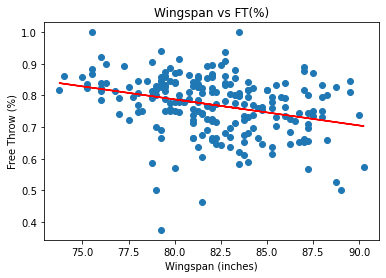

The line of best fit is : y = -0.01x + 1.45
The correlation between both factors is -0.3


In [13]:

(slope, intercept, rvalue, pvalue, stderr) = linregress(wingspan_convert, merged_data_df['FT%'] )
regress_values = np.array(wingspan_convert) * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(wingspan_convert,regress_values, color='red')
plt.scatter(x=wingspan_convert, y=merged_data_df['FT%'])
plt.ylabel('Free Throw (%)')
plt.xlabel('Wingspan (inches)')
plt.title("Wingspan vs FT(%)")
plt.show()
print(f"The line of best fit is : {line_eq}")
correlation = st.pearsonr(wingspan_convert,merged_data_df['FT%'])
print(f"The correlation between both factors is {round(correlation[0],2)}")

## Wingspan vs. 2P%

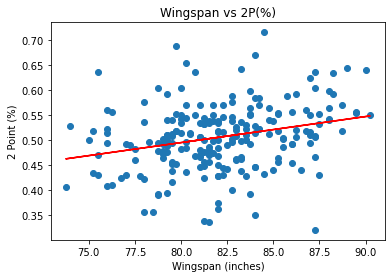

The line of best fit is : y = 0.01x + 0.08
The correlation between both factors is 0.27


In [14]:

(slope, intercept, rvalue, pvalue, stderr) = linregress(wingspan_convert, merged_data_df['2P%'] )
regress_values = np.array(wingspan_convert) * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(wingspan_convert,regress_values, color='red')
plt.scatter(x=wingspan_convert, y=merged_data_df['2P%'])
plt.ylabel('2 Point (%)')
plt.xlabel('Wingspan (inches)')
plt.title("Wingspan vs 2P(%)")
plt.show()
print(f"The line of best fit is : {line_eq}")
correlation = st.pearsonr(wingspan_convert,merged_data_df['2P%'])
print(f"The correlation between both factors is {round(correlation[0],2)}")

## Wingspan vs. 3P%

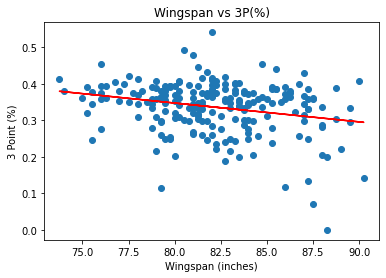

The line of best fit is : y = -0.01x + 0.76
The correlation between both factors is -0.25


In [15]:
(slope, intercept, rvalue, pvalue, stderr) = linregress(wingspan_convert, merged_data_df['3P%'] )
regress_values = np.array(wingspan_convert) * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(wingspan_convert,regress_values,color='red')
plt.scatter(x=wingspan_convert, y=merged_data_df['3P%'])
plt.ylabel('3 Point (%)')
plt.xlabel('Wingspan (inches)')
plt.title("Wingspan vs 3P(%)")
plt.show()
print(f"The line of best fit is : {line_eq}")
correlation = st.pearsonr(wingspan_convert,merged_data_df['3P%'])
print(f"The correlation between both factors is {round(correlation[0],2)}")

## Height vs. FT%

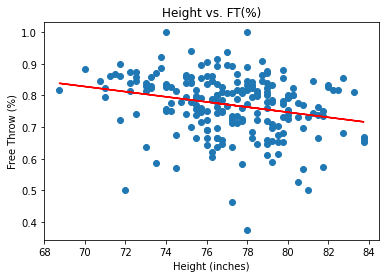

In [32]:


(correlation_coefficient) = st.pearsonr(height_wo_shoes_convert, merged_data_df['FT%'])[0]
(slope, intercept, r_value, p_value, standard_error) = st.linregress(height_wo_shoes_convert, merged_data_df['FT%'])

#Slope formula 'y=mx+b'
y = slope * np.array(height_wo_shoes_convert) + intercept

plt.scatter(x = height_wo_shoes_convert, y = merged_data_df['FT%'])
plt.xlabel('Height (inches)')
plt.ylabel('Free Throw (%)')
plt.title('Height vs. FT(%)')

plt.plot(height_wo_shoes_convert, y, color = 'red')
plt.show()

## Height vs. 2P%

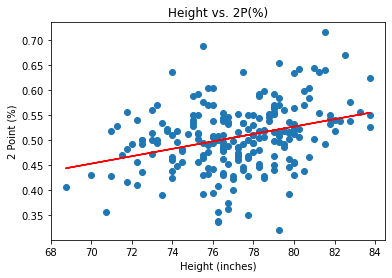

In [33]:


(correlation_coefficient) = st.pearsonr(height_wo_shoes_convert, merged_data_df['2P%'])[0]
(slope, intercept, r_value, p_value, standard_error) = st.linregress(height_wo_shoes_convert, merged_data_df['2P%'])

#Slope formula 'y=mx+b'
y = slope * np.array(height_wo_shoes_convert) + intercept

plt.scatter(x = height_wo_shoes_convert, y = merged_data_df['2P%'])
plt.xlabel('Height (inches)')
plt.ylabel('2 Point (%)')
plt.title('Height vs. 2P(%)')

plt.plot(height_wo_shoes_convert, y, color = 'red')
plt.show()

## Height vs. 3P%

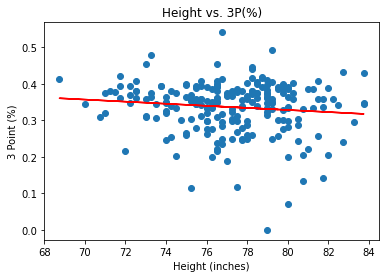

In [34]:

(correlation_coefficient) = st.pearsonr(height_wo_shoes_convert, merged_data_df['3P%'])[0]
(slope, intercept, r_value, p_value, standard_error) = st.linregress(height_wo_shoes_convert, merged_data_df['3P%'])

#Slope formula 'y=mx+b'
y = slope * np.array(height_wo_shoes_convert) + intercept

plt.scatter(x = height_wo_shoes_convert, y = merged_data_df['3P%'])
plt.xlabel('Height (inches)')
plt.ylabel('3 Point (%)')
plt.title('Height vs. 3P(%)')

plt.plot(height_wo_shoes_convert, y, color = 'red')
plt.show()